# Music Genre Classification Using CNNs

In today's digital music landscape, personalized content is key to engaging users and driving customer satisfaction. Various music streaming platforms rely heavily on accurate music genre classification to enhance user experience through curated playlists and personalized recommendations. Accurate genre classification thus has a significant impact on various business metrics, including content discoverability and retention rates.

This project leverages Convolutional Neural Networks (CNNs) to accurately classify music genres based on log-transformed Mel spectrograms. CNNs, which are space-invariant, generally cannot be applied to images which contain meaningful axes; however, with a custom CNN architecture taking into account the time and freqeuncy components of the spectrograms separately, we could improve prediction accuracy, thus offering an innovative solution for music genre categorization.

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from google.colab import drive

from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, MaxPool2D, Conv2D, Dropout, Input, concatenate
from keras import regularizers

In [ ]:
# Function to plot the confusion matrix of the classification task

# actual: true labels, given as a list of numerical values from 0 to num_classes - 1 (not one-hot encoded)
# predicted: predictions, given as a list of numerical values from 0 to num_classes - 1 (not one-hot encoded)
# labels: list of strings with the name of the classes

def plot_confusion_matrix(actual, predicted, labels):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(8, 8)})
  sns.set(font_scale=1.4)
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('Actual class')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [ ]:
# Function to extract the indexes of correctly and uncorrectly predicted data points for a given class

# model: name of the model
# x_train: training data
# ind_class: for which class do you want to observe the wrong predictions? Give it as a numeric value, not a string

def ind_correct_uncorrect(model, x_train, ind_class):
  ind = np.where(np.argmax(y_train, axis=1) == ind_class)[0]
  ind_correct = []
  ind_uncorrect = []
  preds = model.predict(x_train[ind], verbose=0)
  for i in range(len(ind)):
    if np.argmax(preds[i]) == np.argmax(y_train[ind[i]]):
      ind_correct.append(ind[i])
    else:
      ind_uncorrect.append(ind[i])
  return ind_correct, ind_uncorrect

In [ ]:
# Function to plot a given number (i_max * j_max) of spectrograms for a given class

# i_max: number of rows of subplots
# j_max: number of columns of subplots
# x_train: training data
# ind_plot: indexes of the data points that we want to plot

def plot_spectrograms(i_max, j_max, x_train, ind_plot):
  fig, axs = plt.subplots(i_max, j_max, figsize=plt.figaspect(0.5))
  for i in range(i_max):
    for j in range(j_max):
      ind = ind_plot[i*j_max+j]
      axs[i, j].imshow(x_train[ind])
      axs[i, j].grid(False)
  fig.show()

In [ ]:
# Function to print the predictions of those points that were wrongly classified for a given class

# model: name of the model
# x_train: training data
# y_train: training labels, one hot encoded
# ind_wrong: indexes of wrongly predicted points
# ind_class: class (as a numeric value, not a string) for which we want to observe the wrong predictions
# labels: list of strings with the name of the classes

def print_wrong_prediction(model, x_train, y_train, ind_wrong, ind_class, labels):
  print('Wrongly predicted points for true class', labels[ind_class])
  for i in range(len(ind_wrong)):
    preds = model.predict(tf.expand_dims(x_train[ind_wrong[i]], axis=0), verbose=0)
    if np.argmax(preds) != np.argmax(y_train[ind_wrong[i]]):
      print('predicted class is', labels[np.argmax(preds)])

In [ ]:
# Function to compute Grad-CAM heatmap for a given data point and a hidden layer

# imag_array: image (represented as array) on which the heatmap will be produced
# model: name of the model
# layer_name: name of the layer on which the heatmap will be computed

def make_gradcam_heatmap(img_array, model, layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# Function to plot a given number (i_max * j_max) of Grad-CAM heatmaps for a given class

# i_max: number of rows of subplots
# j_max: number of columns of subplots
# x_train: training data
# ind: indexes of the wrongly predicted data for that class
# model: name of model
# layer_name: name of layer on which to compute Grad-CAM

def plot_gradcam_spectrogram(i_max, j_max, x_train, ind, model, layer_name):
  fig, axs = plt.subplots(i_max, j_max, figsize=plt.figaspect(0.5))
  for i in range(i_max):
    for j in range(j_max):
      ind_ = ind[i*j_max+j]
      heatmap = make_gradcam_heatmap(tf.expand_dims(x_train[ind_], axis=0), model, layer_name)
      axs[i, j].matshow(heatmap)
      axs[i, j].grid(False)
  fig.show()

##Downloading the data

The data represents the log-transformed Mel spectrograms derived from the GTZAN dataset. The original GTZAN dataset contains 30-second audio files of 1,000 songs associated with 10 different genres (100 per genre). We have reduced the original data to 4 genres (400 songs) and transformed it to obtain, for each song, 15 log-transformed Mel spectrograms. Each Mel spectrogram is an image file which describes the time, frequency and intensity of a song segment. In particular, the x-axis represents time, the y-axis is a transformation of the frequency (to log scale and then the so-called mel scale) and the color of a point represents the decibels of that frequency at that time (with darker colours indicating lower decibels).

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
npzfile = np.load('./drive/MyDrive/ST456_WT2024_data_assign1.npz')

# features
x_train = npzfile['x_train']
x_val = npzfile['x_val']
x_test = npzfile['x_test']

# one hot encoded labels
y_train = npzfile['y_train']
y_val = npzfile['y_val']
y_test = npzfile['y_test']

# numerical labels
y_train_num = npzfile['y_train_num']
y_val_num = npzfile['y_val_num']
y_test_num = npzfile['y_test_num']

In [ ]:
# the classes correspond to 4 music genres, in this order
classes = ['classical', 'disco', 'metal', 'rock']

The training data represents approximately 66% of the total number of data points, the validation set 14% and test set 30%.

The labels of the classes are such that:
- the first class corresponds to classical music
- the second to disco music
- the third to metal music
- the fourth to rock music

In [ ]:
x_train.shape

(3959, 80, 80, 1)

In [ ]:
x_test.shape

(1172, 80, 80, 1)

The goal is to train a CNN-based classifier on the Mel spectrograms to predict the corresponding music genres.

In [ ]:
tf.keras.utils.set_random_seed(42) # setting the seed to ensure reproducibility
tf.config.experimental.enable_op_determinism()

In [ ]:
model = Sequential()
model.add(Conv2D(filters=4, kernel_size=(5,5), input_shape=(80,80,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=8, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(50,activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dense(4, activation='softmax'))

model.summary()

model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['acc']) # we optimise using the mini-batch stochastic gradient descent algorithm

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 4)         104       
                                                                 
 max_pooling2d (MaxPooling2  (None, 40, 40, 4)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 8)         808       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 16)        3216      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 16)        0

#### Q. How many parameters does the model train? Before performing the training, do you expect this model to overfit? Which aspects would influence the overfitting (or not) of this model?

This model is training 84382 parameters.

Before training, we expect that the model will likely overfit. This is due to two main reasons:
- There are a large number of training parameters (84382), because we have multiple layers. This can lead to model overfitting because the large number of parameters indicates that our model is complex.
- The training data is also very limited (3959), especially in comparison with the large number of training parameters. Since there's not enough data for the model to train on, it may not be able to accurately classify unseen data.

In [ ]:
# model fitting
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/20
124/124 [==============================] - 23s 181ms/step - loss: 2.0292 - acc: 0.4971 - val_loss: 2.0783 - val_acc: 0.4925
Epoch 2/20
124/124 [==============================] - 19s 155ms/step - loss: 1.6543 - acc: 0.6908 - val_loss: 1.6249 - val_acc: 0.6858
Epoch 3/20
124/124 [==============================] - 21s 171ms/step - loss: 1.5079 - acc: 0.7300 - val_loss: 1.4574 - val_acc: 0.7296
Epoch 4/20
124/124 [==============================] - 22s 179ms/step - loss: 1.4307 - acc: 0.7487 - val_loss: 1.3984 - val_acc: 0.7560
Epoch 5/20
124/124 [==============================] - 20s 166ms/step - loss: 1.3398 - acc: 0.7749 - val_loss: 1.3236 - val_acc: 0.7756
Epoch 6/20
124/124 [==============================] - 20s 160ms/step - loss: 1.2574 - acc: 0.7921 - val_loss: 1.2940 - val_acc: 0.7699
Epoch 7/20
124/124 [==============================] - 22s 177ms/step - loss: 1.2096 - acc: 0.7969 - val_loss: 1.1932 - val_acc: 0.7871
Epoch 8/20
124/124 [==============================] - 2

#### Q. Plot the loss function and the accuracy per epoch for the train and validation sets.

Text(0.5, 0.98, '2 x (CNN + MaxPooling) + Dropout')

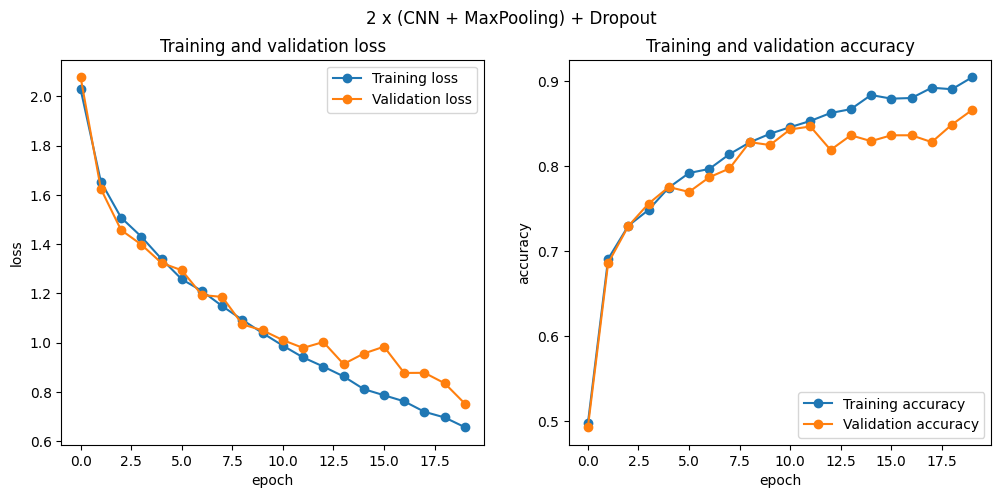

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(history.history['loss'],'-o', label='Training loss')
ax1.plot(history.history['val_loss'],'-o', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(loc='upper right')
ax2.plot(history.history['acc'],'-o', label='Training accuracy')
ax2.plot(history.history['val_acc'],'-o', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(loc='lower right')
f.suptitle('2 x (CNN + MaxPooling) + Dropout')

As we can see from the plots:
- Training and validation loss per epoch: After around the 12th epoch, the validation loss doesn't consistently go down anymore even though the training loss reduces. This is indicative of overfitting.
- Training and validation accuracy per epoch: The training accuracy continues to increase, but the validation accuracy does not improve after around the 12th epoch. This is a sign of overfitting.

#### Q: Which accuracy do you obtain on the test set?

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]
# print test accuracy
print('Test accuracy %.2f%%' % accuracy)

Test accuracy 87.37%


Thus, we obtain the above test accuracy of 87.37% from this model.

#### Q: Plot the confusion matrices of the classification task on the train set and test set. What do you observe from this metric? Which classes display more correct predictions? And wrong?

In [ ]:
predictions = model.predict(x_test)

37/37 [==============================] - 2s 46ms/step


In [ ]:
predictions

array([[2.2372162e-04, 9.1544837e-01, 5.2843364e-03, 7.9043627e-02],
       [4.7578830e-03, 8.5225925e-02, 3.9794031e-01, 5.1207584e-01],
       [4.5613162e-03, 1.0017093e-02, 6.0033757e-02, 9.2538774e-01],
       ...,
       [5.0844883e-06, 9.2356198e-04, 9.9759161e-01, 1.4797037e-03],
       [9.8075646e-01, 8.9142835e-03, 8.8576906e-09, 1.0329253e-02],
       [1.0973399e-03, 1.8614051e-01, 8.5283145e-03, 8.0423385e-01]],
      dtype=float32)

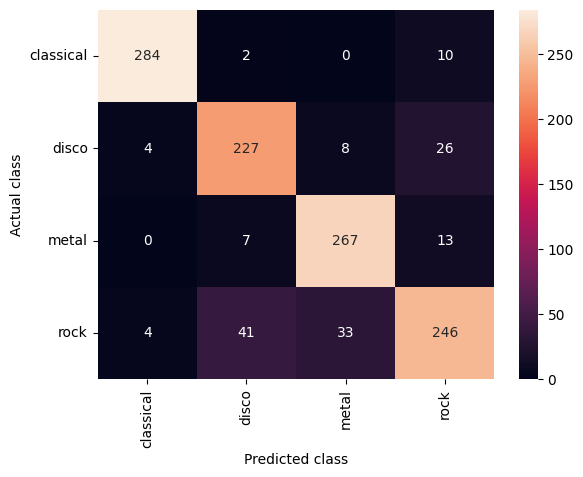

In [ ]:
plot_confusion_matrix(y_test_num, np.argmax(predictions, axis=1), labels=classes)

In [ ]:
pd.DataFrame(y_test_num).value_counts()

3    324
0    296
2    287
1    265
dtype: int64

From the confusion matrix we can see that classical music data points have the least number of incorrect classifications. The rock music genre has the highest number of incorrect classifications, with 43 data points being incorrectly classified as disco music and 35 as metal.

In [ ]:
dic = {
    'classical': 284/296,
    'disco': 227/265,
    'metal': 267/287,
    'rock': 246/324,
}
dic

{'classical': 0.9594594594594594,
 'disco': 0.8566037735849057,
 'metal': 0.9303135888501742,
 'rock': 0.7592592592592593}

Thus, classical music is correctly classified 95.95% times, followed by metal music, disco music and finally the rock music genre is correctly classified 75.93% of the time.

#### Q: Extract the indexes of the training data that were predicted correctly and incorrectly, per each class. For each music genre, perform the following steps:

- Plot the 12 mel spectrograms of the first 6 data points which were predicted correctly and the first 6 which were predicted wrongly. Do you observe some differences among music genres?
- Print the predicted classes of the first 6 data points which were predicted wrongly.
- Using the Grad-CAM method, print the heatmaps of the last pooling layer for the same 12 extracts (6 correct + 6 wrong). Comment on the heatmaps obtained. Do you observe differences among the heatmaps of different music genres? Can you understand why the model got some predictions wrong?

In [ ]:
ind = ind_correct_uncorrect(model, x_train, 0)
ind2 = ind_correct_uncorrect(model, x_train, 1)
ind3 = ind_correct_uncorrect(model, x_train, 2)
ind4 = ind_correct_uncorrect(model, x_train, 3)

In [ ]:
myextract = ind[0][0:6]+ind2[0][0:6]+ind3[0][0:6]+ind4[0][0:6]
print(myextract)

[0, 4, 6, 8, 12, 14, 1, 10, 18, 23, 49, 53, 3, 7, 9, 17, 31, 32, 2, 5, 13, 19, 20, 24]


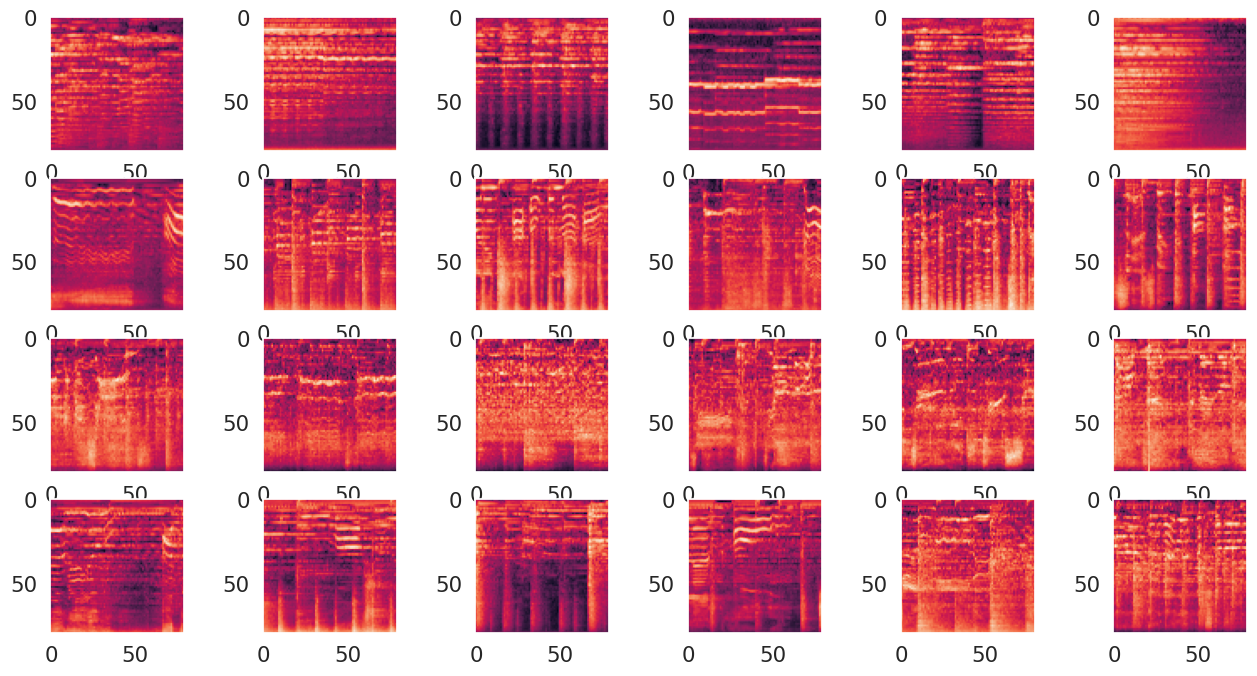

In [ ]:
#For the first 6 correct predictions for each genre
#First row: 6 correctly predicted as classical genre
#Second row: 6 correctly predicted as disco genre
#Third row: 6 correctly predicted as metal genre
#Fourth row: 6 correctly predicted as rock genre
plot_spectrograms(4, 6, x_train, myextract)

We can observe some differences in the spectrograms of the 4 genres. We know that the color of a point represents the decibels of that frequency at that time (with darker colours indicating lower decibels), which can also somewhat help us make distinctions.

For example,
- The Mel spectrogram for the classical genre has a pattern similar to lots of horizontal line segments
- For the disco genre, there are vertical sections with the top edge having more darker points.
- For the metal genre, the image largely consists of lighter coloured points (indicating higher decibels) and no lines as such. The bottom edge also all have darker points.
- In rock, the bottom section of the Mel spectrogram has wider-spaced vertical sections which are largely composed of darker coloured points (indicating lower decibels).

### Comparing the Grad-CAMs of the 4 genres to see if we can observe any differences:

In [ ]:
myextract2 = ind[1][0:6]+ind2[1][0:6]+ind3[1][0:6]+ind4[1][0:6]
print(myextract2)

[184, 306, 331, 447, 491, 664, 265, 387, 436, 437, 483, 551, 45, 106, 131, 260, 304, 471, 11, 15, 47, 59, 62, 67]


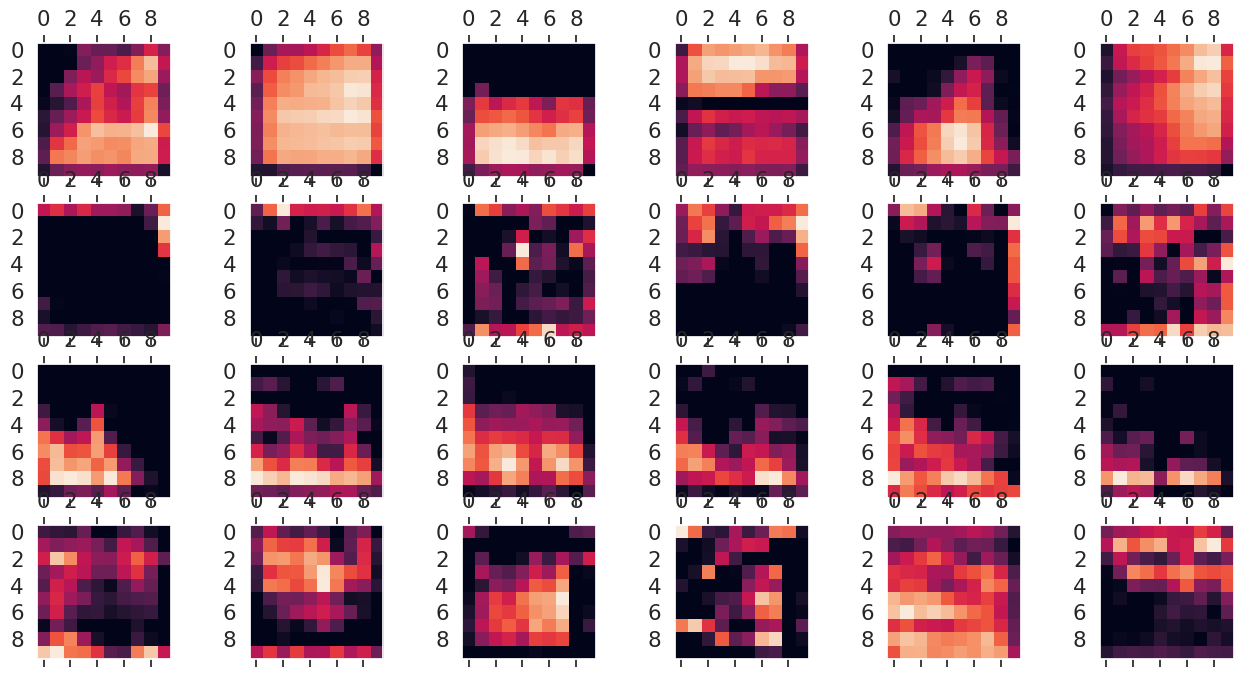

In [ ]:
#For the first 6 correct predictions for each genre
#First row: 6 correctly predicted as classical genre
#Second row: 6 correctly predicted as disco genre
#Third row: 6 correctly predicted as metal genre
#Fourth row: 6 correctly predicted as rock genre
plot_gradcam_spectrogram(4, 6, x_train, myextract, model, 'max_pooling2d_2')

From the Grad-CAMs of the correctly classified genres, we can make the observations:
*   For the classical genre, more than half the area of the spectrogram seems to have importance; upon looking at the spectrograms for this genre, it seems the highlighted areas are those that are darker.
*   For the disco genre, it seems that mostly a small area at the **top right portion** of the Mel spectrogram is being considered.
*   For the metal genre, the **bottom left portion** is largely being deemed as important.
*   For the rock genre, it seems hard to figure out any pattern; upon looking at the spectrograms for this genre, it seems the highlighted areas are those that are darker.

Thus, there are certainly differences among the heatmaps of different music genres.

### Let us also take a look at the Grad-CAMs of the wrongly classified genres and see if we can interpret them:

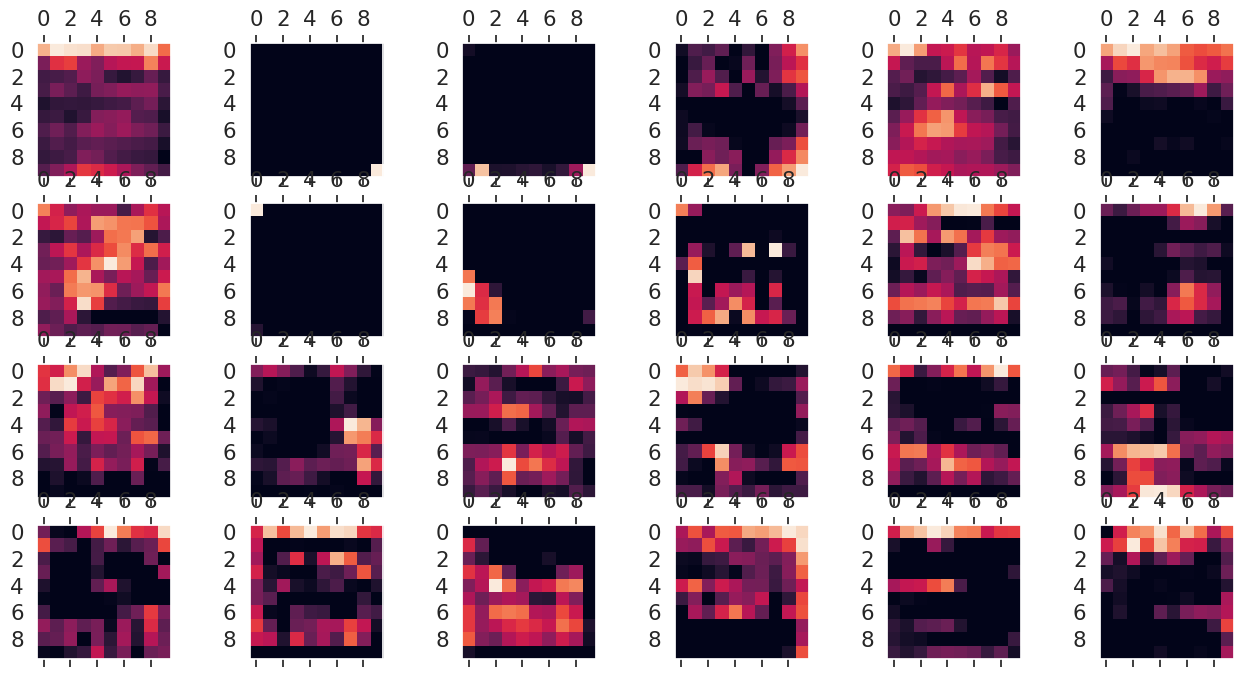

In [ ]:
plot_gradcam_spectrogram(4, 6, x_train, myextract2, model, 'max_pooling2d_2')

In [ ]:
a = print_wrong_prediction(model, x_train, y_train, ind[1][0:6], 0, classes)
b = print_wrong_prediction(model, x_train, y_train, ind2[1][0:6], 1, classes)
c = print_wrong_prediction(model, x_train, y_train, ind3[1][0:6], 2, classes)
d = print_wrong_prediction(model, x_train, y_train, ind4[1][0:6], 3, classes)

Wrongly predicted points for true class classical
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is disco
predicted class is rock
predicted class is disco
Wrongly predicted points for true class disco
predicted class is rock
predicted class is rock
predicted class is metal
predicted class is rock
predicted class is rock
predicted class is rock
Wrongly predicted points for true class metal
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
Wrongly predicted points for true class rock
predicted class is disco
predicted class is disco
predicted class is metal
predicted class is disco
predicted class is disco
predicted class is disco


Although not easily apparent, we can observe that whenever there is a wrong classification of "disco", its mainly the top right portion in the Grad-CAM that is highlighted (which is what we had noticed earlier for this genre's correct classifications as well). For the "metal" genre as well, we can see that the case of the bottom left portion being highlighted. This can be the reason for the wrong classification of a spectrogram into the disco/metal genres.

Most of the wrong classifications are "rock", which suggests that it is not very distinguishable and often has overlapping components, thus the model makes the wrong classification. Even earlier, we were not able to clearly interpret its Grad-CAMs.

We can also see that some of the heatmaps have no clear area hightlighted; some of them (like the second and third heatmap in the first row) are largely empty of any highlighted regions. This can lead us to assume that for this particular spectrogram, the Grad-CAM was unable to spot a region of importance for the model decision. Hence, that could be the reason for the wrong classification.

#### Q: What are your thoughts about the applicability of the Grad-CAM tool on this data?

Very simply put, Grad-CAM (which stands for Gradient-weighted Class Activation Mapping) looks at the pixels that were more important for the model when making a decision. It helps us visualise the hidden decisions made by the CNN, thus increasing interpretability of the model and aiding in the enhancement of its performance.

For our data, Grad-CAM generated heatmaps that highlighted the most important regions of the Mel spectrogram for model decisions, by analysing the last pooling layer of our extracted data. We were able to make some interpretations from these Grad-CAMs to see what regions of the image the model was considering when classifying these spectrograms into the 4 genres (for example: it highlighted mainly the bottom left region for metal music, top right for disco music). However, for classical and rock music, it was hard to understand the features/regions that were being deemed as important.

The understanding is that Grad-CAM is highly class-discriminative (i.e. it works well when the class is localised within the image; for example, the image may contain a cat, and the Grad-CAM will highlight the region of the image that the model took into consideration to make the predicted output of "cat"). However, our audio data does not itself have separate "classes" of sounds; rather, a spectrogram can be thought of as a bunch of sound data points making up accumulated or overlapping sounds. It can be difficult, therefore, to distinguish between simultaneous or overlapping sounds. To further explain this rationale: suppose we have images of cats and dogs but the images we feed our model are very zoomed-in images of just the animals' fur. (Note: Of course, visual representations of sound are not similar to physical objects, but this is an example to illustrate what we can liken our spectrogram data to be: just a part of the overall sound.)

Thus, our Mel spectrograms contains many small overlapping features and Grad-CAM might have difficulty picking out meaningful features from these. This may be indicative of a limit of using this method to understand individual model predictions for our data. One would need quite some background information to understand the heatmaps; a possible avenue would be converting the Mel spectrograms back to audio, in order to make it more interpretable to humans, than let these remain as images.

To conclude: Grad-CAM has wide applicability for understanding the decisions made by CNNs; we gained some important insights about the model's decisions for classifying disco and metal music. However due to the large number of small overlapping features in the Mel Spectrograms of the 4 music genres, Grad-CAM (which seems to work best for data that is highly class-discriminative) may have difficulty in helping us truly understand how the model distinguishes amongst the 4 classes in our data.  


# Disentangling time and frequency

We know that each Mel spectrogram is an image file in which the X-axis represents time and the Y-axis is a transformation of the frequency. CNNs are designed by considering spatial invariance, which means that an image feature or object is the same no matter where it is in the image. For our data, i.e., Mel spectrograms,  this MAY be true when objects are shifted in the X-axis (time), but certainly not when they are shifted in the Y-axis (frequency) because this would influence the meaning of the data point. For instance, a low-pitched sound shifted in the X-axis can arguably be thought to be the same - a sound can be thought to be the same regardless of when it happens. However, when shifted in the Y-axis, the meaning will change to now indicate that the sound is either higher or lower pitched than before, which isn't accurate.

Thus, we now attempt to propose a CNN architecture that takes into account differently the time and frequency components of the spectrograms.

## Rational Architecture

Since we need to consider the time and frequency components of the spectrograms separately, we can decide to have 2 branches in the CNN architecture which each capture the vertical and horizontal features of the spectrogram separately. This way, the model will take into account the features along the height and along the width of the spectrograms separately, effectively considering the two components along the axes in the manner that we require.

Based on this reasoning, the following is our new CNN architecture:
- an Input layer to take in the input shape of the spectrograms

CONSIDERING TIME (X-axis, horizontal feature of the spectrogram):
- a 2D convolutional layer with the kernel size set as (1,5) to subsample the spectrogram horizontally. There is also padding, default stride (which is (1,1)), ReLU activation function and default weight and bias initialisations.
- another 2D convolutional layer with kernel size (1,5), padding, default stride, ReLU activation function and default weight and bias initialisations to capture more complex horizontal patterns.
- a 2D max pooling layer with size 2 and stride 2.
- a Dropout layer to help prevent model overfitting by forcing the model to learn more robust features and prevent it from memorizing the training data too much

CONSIDERING FREQUENCY (Y-axis, vertical feature of the spectrogram):
- a 2D convolutional layer with the kernel size set as (5,1) to subsample the spectrogram vertically. There is also padding, default stride (which is (1,1)), ReLU activation function and default weight and bias initialisations.
- another 2D convolutional layer with kernel size (5,1), padding, default stride, ReLU activation function and default weight and bias initialisations to capture more complex vertical patterns
- a 2D max pooling layer with size 2 and stride 2
- a Dropout layer to help prevent model overfitting

CONCATENATING THE BRANCHES:
- concatenating the outputs of the last MaxPool2D layers of both branches

ADDITIONAL CNN LAYERS:
- a 2D convolutional layer now with kernel size set as (5,5), default stride, ReLU activation function and default weight and bias initialisations
- a 2D convolutional layer now with kernel size set as (5,5), default stride, ReLU activation function and default weight and bias initialisations
- a 2D max pooling layer with size 2 and stride 2
- a Dropout layer to help prevent model overfitting

FINALLY:
- a layer transforming the output filters to a 1D vector.
- a dense layer made of 50 neurons, ReLU activation
- a Dropout layer to help prevent model overfitting
- a dense output layer with the required number of neurons and activation function.

In [ ]:
from keras.models import Model
from keras.layers import Input, concatenate

input_layer = Input(shape=(80, 80, 1))

# Pathway for processing time axis
time = Conv2D(filters=64, kernel_size=(1,5), padding='same', activation='relu')(input_layer)
time = Conv2D(filters=128, kernel_size=(1,5), padding='same', activation='relu')(time)
maxpool_time = MaxPool2D(pool_size=2, strides=2)(time)
maxpool_time = Dropout(0.25)(maxpool_time)

# Pathway for processing frequency axis
freq = Conv2D(filters=64, kernel_size=(5,1), padding='same', activation='relu')(input_layer)
freq = Conv2D(filters=128, kernel_size=(5,1), padding='same', activation='relu')(freq)
maxpool_freq = MaxPool2D(pool_size=2, strides=2)(freq)
maxpool_freq = Dropout(0.25)(maxpool_freq)

myconcat = concatenate([maxpool_time, maxpool_freq], axis=-1)

mycnn = Conv2D(filters=256, kernel_size=5, padding='same', activation='relu')(myconcat)
mycnn = Conv2D(filters=256, kernel_size=5, padding='same', activation='relu')(mycnn)
maxpool_cnn = MaxPool2D(pool_size=2, strides=2)(mycnn)
maxpool_cnn = Dropout(0.25)(maxpool_cnn)

flatten = Flatten()(maxpool_cnn)
mydense = Dense(50, activation='relu')(flatten)
mydense = Dropout(0.5)(mydense)
output = Dense(4, activation='softmax')(mydense)

custom_model = Model(inputs=input_layer, outputs=output)
custom_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 80, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 80, 80, 64)           384       ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 80, 80, 64)           384       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 80, 80, 128)          41088     ['conv2d[0][0]']              
                                                                                              

In [ ]:
# Compile the model
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = custom_model.fit(x_train, y_train, batch_size=256, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 31s 2s/step - loss: 2.1258 - accuracy: 0.3769 - val_loss: 1.0434 - val_accuracy: 0.5293
Epoch 2/20
16/16 [==============================] - 24s 1s/step - loss: 0.9912 - accuracy: 0.5456 - val_loss: 0.7888 - val_accuracy: 0.6778
Epoch 3/20
16/16 [==============================] - 24s 2s/step - loss: 0.8532 - accuracy: 0.6145 - val_loss: 0.7051 - val_accuracy: 0.6870
Epoch 4/20
16/16 [==============================] - 25s 2s/step - loss: 0.7869 - accuracy: 0.6550 - val_loss: 0.6201 - val_accuracy: 0.7468
Epoch 5/20
16/16 [==============================] - 25s 2s/step - loss: 0.6847 - accuracy: 0.6987 - val_loss: 0.4963 - val_accuracy: 0.8044
Epoch 6/20
16/16 [==============================] - 25s 2s/step - loss: 0.6141 - accuracy: 0.7320 - val_loss: 0.4885 - val_accuracy: 0.8170
Epoch 7/20
16/16 [==============================] - 25s 2s/step - loss: 0.5440 - accuracy: 0.7605 - val_loss: 0.3704 - val_accuracy: 0.8527
Epoch 8/20
16/16 [==

Text(0.5, 0.98, '2 x (CNN + MaxPooling) + Dropout')

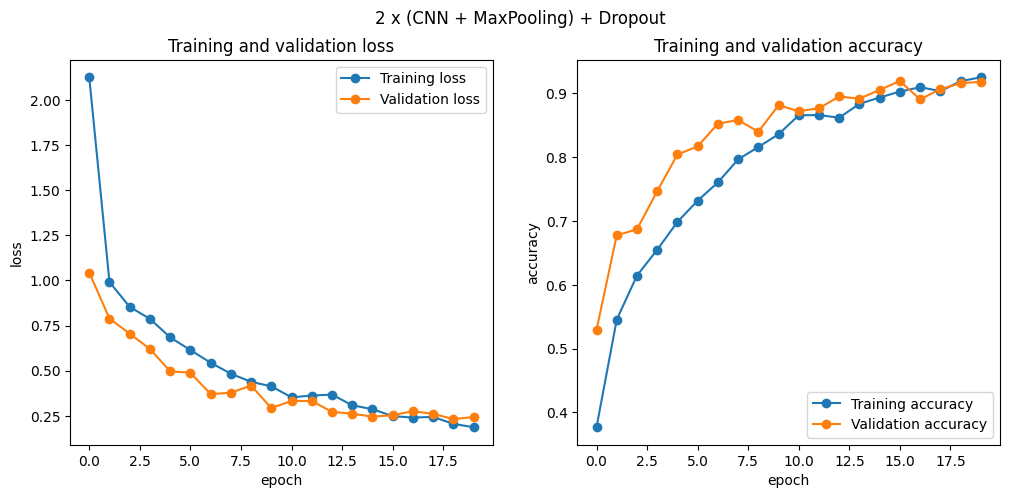

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(history.history['loss'],'-o', label='Training loss')
ax1.plot(history.history['val_loss'],'-o', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(loc='upper right')
ax2.plot(history.history['accuracy'],'-o', label='Training accuracy')
ax2.plot(history.history['val_accuracy'],'-o', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(loc='lower right')
f.suptitle('2 x (CNN + MaxPooling) + Dropout')

In [ ]:
score = custom_model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]
# print test accuracy
print('Test accuracy %.2f%%' % accuracy)

Test accuracy 92.66%


As we can see, we have obtained nearly 93% test accuracy with this custom CNN architecture. Let us now plot the confusion matrices of both the training and test sets.

In [ ]:
train_predictions = custom_model.predict(x_train)

124/124 [==============================] - 4s 34ms/step


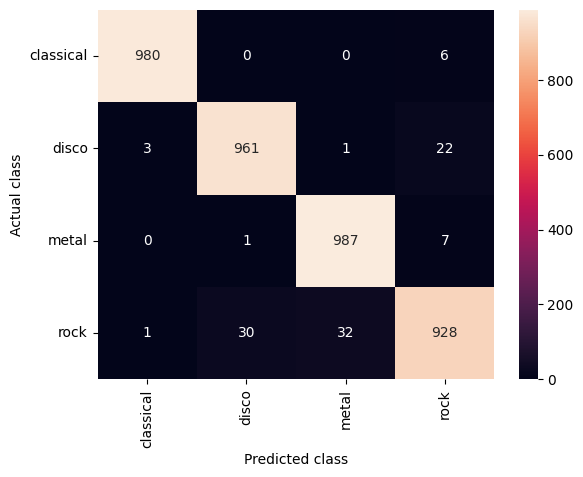

In [ ]:
plot_confusion_matrix(y_train_num, np.argmax(train_predictions, axis=1), labels=classes)

In [ ]:
test_predictions = custom_model.predict(x_test)

37/37 [==============================] - 1s 34ms/step


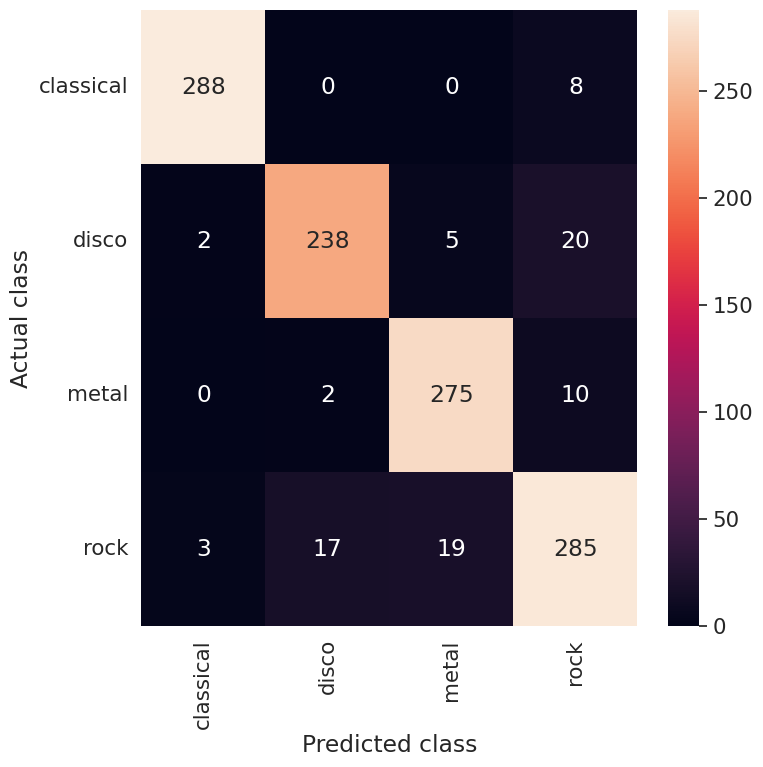

In [ ]:
plot_confusion_matrix(y_test_num, np.argmax(test_predictions, axis=1), labels=classes)

As we can see, these confusion matrices show that now the model is more successful in identifying music genres. As before, the classical music genre has the most number of correct classifications and rock music the least.

# Conclusion

In the problem of music genre classification, our objective was to train a CNN-based classifier on the Mel spectrograms to predict the corresponding music genres.

Since a Mel spectrogram is an image file in which the X-axis represents time and the Y-axis is a transformation of the frequency, we reasoned that the traditional CNN which is spatially invariant might not work optimally for these visual spectrogram representations of sounds wherein the axes are meaningful.

Thus, we attempted to propose a CNN architecture with two branches that took into account differently the time and frequency components of the spectrograms, and then concatenated them before further model building. We obtained a 92.66% test accuracy with this architecture, thus successfully capturing the time and frequency components and achieving better model performance.